# 0. 사용할 패키지 불러오기

In [1]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model

# 1. 데이터 불러오기

In [2]:
import numpy as np
import glob
import sys
from sklearn.model_selection import train_test_split

x_train = np.empty((0, 120, 320, 1))
y_train = np.empty((0, 4))

training_data = glob.glob('./training_data/*.npz')

for single_npz in training_data:
    with np.load(single_npz) as data:
        x = data['train']
        y = data['train_labels']
    x = np.reshape(x, (-1, 120, 320, 1))
    x_train = np.vstack((x_train, x))
    y_train = np.vstack((y_train, y))


# train test split, 7:3
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, random_state = 42)

y_train = y_train[:,:-1]
y_test = y_test[:,:-1]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(969, 120, 320, 1) (969, 3)
(416, 120, 320, 1) (416, 3)


# 데이터 확인

In [3]:
#import pandas as pd

#y_data = pd.DataFrame(y_total[:, :])

In [4]:
#y_data.count()

In [5]:
#left = y_data.loc[y_data[:][0] == 1]

In [6]:
#left.count()

In [7]:
#right = y_data.loc[y_data[:][1] == 1]

In [8]:
#right.count()

In [9]:
#forward = y_data.loc[y_data[:][2] == 1]

In [10]:
#forward.count()

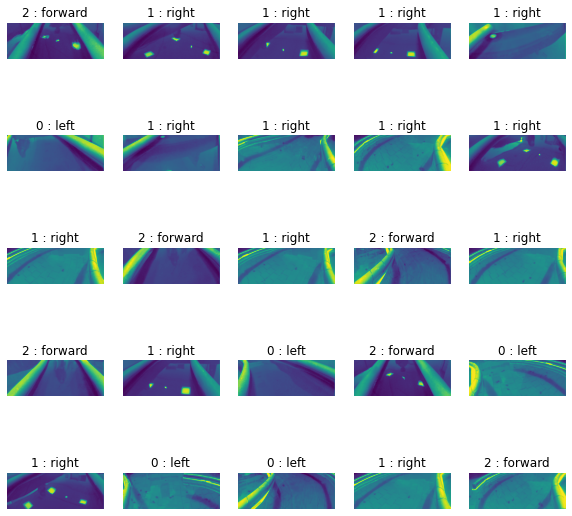

In [11]:
# 데이터 확인

from matplotlib import pyplot as plt
%matplotlib inline

plt_row = 5
plt_col = 5
plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):

    sub_plt = axarr[int(i/plt_row), int(i%plt_col)]
    sub_plt.axis('off')
    sub_plt.imshow(x_train[i].reshape(120, 320))
    
    label = np.argmax(y_train[i])
                      
    if label == 0 :
        direction = 'left'
    elif label == 1:
        direction = 'right'
    elif label == 2:
        direction = 'forward'
    elif label == 3:
        direction = 'backward'
                      
    sub_plt_title = str(label) + " : " + direction
    sub_plt.set_title(sub_plt_title)

plt.show()

# 3. 모델 생성

In [12]:
# image size = 160 x 320
def custom_net():
    
    # model setting
    H = 120
    W = 320
    CH = 1

    inputShape = (H, W, CH)

    activation = 'relu'
    keep_prob_conv = 0.25
    keep_prob_dense = 0.5

    #init = 'glorot_normal'
    #init = 'he_normal'
    init = 'he_uniform'
    chanDim = -1
    classes = 3
    
    model = Sequential()
    
    # CONV => RELU => POOL
    model.add(Conv2D(3, (3, 3), padding="valid", input_shape=inputShape, kernel_initializer=init, activation=activation))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(9, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(18, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(32, (3, 3), padding="valid", kernel_initializer=init, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(80, kernel_initializer=init, activation=activation))
    model.add(Dropout(keep_prob_dense))
    
    model.add(Dense(15, kernel_initializer=init, activation=activation))
    model.add(Dropout(keep_prob_dense))
    
    # softmax classifier
    model.add(Dense(classes , activation = 'softmax'))
    
    return model

In [13]:
model = custom_net()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 318, 3)       30        
_________________________________________________________________
batch_normalization (BatchNo (None, 118, 318, 3)       12        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 159, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 157, 9)        252       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 78, 9)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 76, 18)        1476      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 38, 18)        0

In [14]:
import pydot

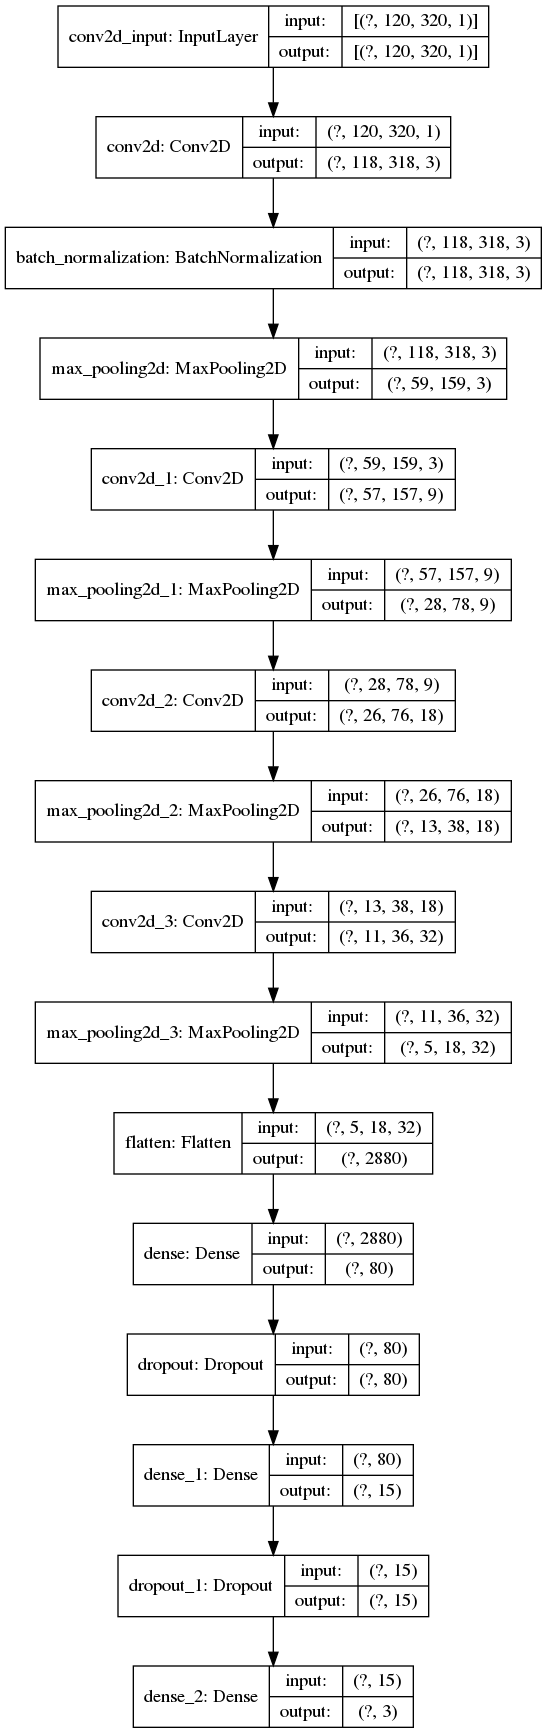

In [15]:
from tensorflow.python.keras.utils import plot_model
plot_model(model, to_file= 'video_net_plot.png', show_shapes = True, show_layer_names = True)

# 4. 모델 파라미터 셋팅

적은 수의 이미지 데이터가 존재할 경우 데이터를 늘리는 용도로 사용

In [16]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [18]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [19]:
# initialize the model
# EPOCHS = 50
# INIT_LR = 1e-3
# BS = 32
# split_ratio = 0.2

In [20]:
EPOCHS = 50
INIT_LR = 1e-4
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
 

[INFO] compiling model...


# 5. 모델 훈련

In [21]:
hist = model.fit(x_train, y_train, 
                 epochs=EPOCHS, batch_size=BS, 
                 validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Train on 775 samples, validate on 194 samples
Epoch 1/50
775/775 [==============================] - 9s 12ms/sample - loss: 12.5715 - accuracy: 0.3058 - val_loss: 9.1065 - val_accuracy: 0.3918
Epoch 2/50
775/775 [==============================] - 8s 10ms/sample - loss: 8.4544 - accuracy: 0.3290 - val_loss: 3.2111 - val_accuracy: 0.3969
Epoch 3/50
775/775 [==============================] - 8s 10ms/sample - loss: 6.7053 - accuracy: 0.3690 - val_loss: 2.0180 - val_accuracy: 0.3505
Epoch 4/50
775/775 [==============================] - 8s 10ms/sample - loss: 6.3885 - accuracy: 0.3535 - val_loss: 1.6207 - val_accuracy: 0.3969
Epoch 5/50
775/775 [==============================] - 7s 9ms/sample - loss: 4.8764 - accuracy: 0.3600 - val_loss: 1.4177 - val_accuracy: 0.4742
Epoch 6/50
775/775 [==============================] - 8s 10ms/sample - loss: 3.6561 - accuracy: 0.4039 - val_loss: 1.3169 - val_accuracy: 0.5258
Epoch 7/50
775/775 [==============================] - 7s 10ms/sample - loss: 3.9034 

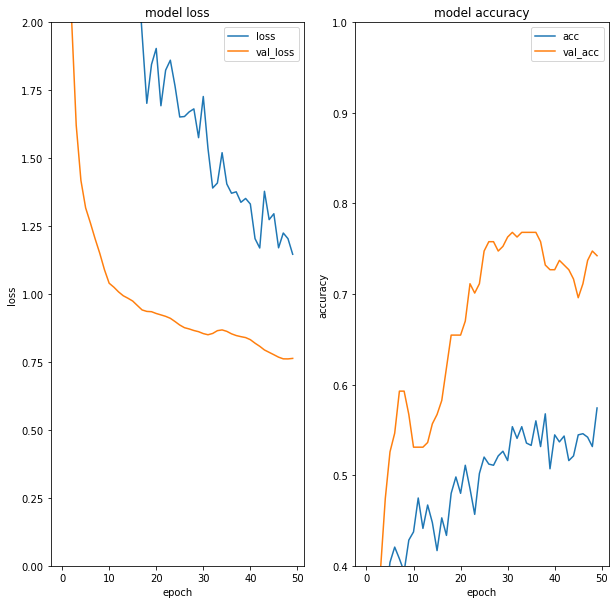

In [22]:
plt.subplot(1, 2, 1)
plt.title('model loss')
plt.plot(hist.history['loss'], label="loss")
plt.plot(hist.history['val_loss'], label="val_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0,2))

plt.subplot(1, 2, 2)
plt.title('model accuracy')
plt.plot(hist.history['accuracy'], label="acc")
plt.plot(hist.history['val_accuracy'], label="val_acc")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.ylim((0.4, 1))


plt.show();

# 6. 모델 결과 확인

In [181]:
#l_model = load_model('./model_data/VGG_model.h5')

In [182]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

1189/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [183]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 1, Predict : 1
True : 0, Predict : 0
True : 0, Predict : 0
True : 2, Predict : 2
True : 2, Predict : 0
True : 0, Predict : 0
True : 0, Predict : 0
True : 2, Predict : 2
True : 0, Predict : 0
True : 2, Predict : 2


# 7. 최종 모델 훈련

In [184]:
x_total = np.vstack((x_train, x_test))
y_total = np.vstack((y_train, y_test))

print(x_total.shape)
print(y_total.shape)

(3963, 120, 320, 1)
(3963, 3)


In [185]:
early_stopping = EarlyStopping(monitor='loss', patience=10)

In [186]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=5, min_lr=0.0001)

In [187]:
EPOCHS = 50
INIT_LR = 1e-4
BS = 256
split_ratio = 0.2

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


In [188]:
hist = model.fit(x_total, y_total, 
                 epochs=EPOCHS, batch_size=BS, 
                 #validation_split=split_ratio, 
                 verbose = 1
                 ,callbacks=[reduce_lr]
                )

Train on 3963 samples
Epoch 1/50
3963/3963 [==============================] - 35s 9ms/sample - loss: 0.6198 - accuracy: 0.7197
Epoch 2/50
3963/3963 [==============================] - 34s 9ms/sample - loss: 0.6096 - accuracy: 0.7214
Epoch 3/50
3963/3963 [==============================] - 34s 9ms/sample - loss: 0.6043 - accuracy: 0.7280
Epoch 4/50
3963/3963 [==============================] - 33s 8ms/sample - loss: 0.5932 - accuracy: 0.7318
Epoch 5/50
3963/3963 [==============================] - 34s 9ms/sample - loss: 0.5768 - accuracy: 0.7366
Epoch 6/50
3963/3963 [==============================] - 33s 8ms/sample - loss: 0.5846 - accuracy: 0.7305
Epoch 7/50
3963/3963 [==============================] - 34s 8ms/sample - loss: 0.5809 - accuracy: 0.7416
Epoch 8/50
3963/3963 [==============================] - 34s 9ms/sample - loss: 0.5726 - accuracy: 0.7484
Epoch 9/50
3963/3963 [==============================] - 34s 9ms/sample - loss: 0.5646 - accuracy: 0.7492
Epoch 10/50
3963/3963 [==========

In [189]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=BS)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

1189/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [191]:
xhat_idx = np.random.choice(x_test.shape[0], 10)
xhat = x_test[xhat_idx]

yhat_classes = model.predict_classes(xhat)

for i in range(10):
    print('True : ' + str(np.argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat_classes[i]))

True : 2, Predict : 1
True : 0, Predict : 0
True : 0, Predict : 0
True : 2, Predict : 2
True : 0, Predict : 0
True : 0, Predict : 0
True : 1, Predict : 1
True : 0, Predict : 0
True : 0, Predict : 0
True : 1, Predict : 1


# 8. 모델 저장

In [192]:
model.save('./model_data/video_model_5.h5')